In [1]:
import sys
import logging
import os
import math
import json
from tqdm import tqdm
import warnings
from IPython.display import display, Audio

import numpy as np
import librosa

import torch

import scdata

sys.path.append('..')
logging.getLogger().setLevel(logging.INFO)
warnings.filterwarnings('ignore')

from aural_travels.data import soundcloud
from aural_travels.train import visualizer

MODEL_DIR = '/home/leo/src/aural-travels/models/nat_vqgan_layers16'
DATA_DIR = '/home/leo/src/scdata'

In [2]:
with open(os.path.join(MODEL_DIR, 'params.json')) as f:
    params = json.load(f)
    
params

{'soundcloud_data_dir': '/home/leo/src/scdata',
 'dataset': 'soundcloud',
 'num_workers': 64,
 'batch_size': 64,
 'gradient_accumulation': 2,
 'num_epochs': 1000,
 'hidden_size': 512,
 'num_layers': 16,
 'num_heads': 8,
 'attention_dropout': 0.0,
 'ffnn_dropout': 0.0,
 'lr': 0.001,
 'output_dir': 'models/nat_vqgan_layers16',
 'sample_secs': 2.0,
 'n_fft': 2048,
 'hop_length': 1024,
 'save_steps': 100,
 'eval_steps': 100,
 'encoding_dir': 'models/encoding/vqgan',
 'non_autoregressive': True,
 'corrupt_image_mode': 'uniform_and_full',
 'seed': 42,
 'toy_data': False,
 'expose_steps': None,
 'expose_alpha': 0.5,
 'axial_attention': False,
 'image_repr': 'vqgan'}

In [3]:
#split = 'training'
split = 'validation'

dataset = visualizer.load_dataset(params,
                                  split,
                                  torch.load(f'../models/encoding/{params["image_repr"]}/{split}.pt'))
image_repr = visualizer.create_image_repr(params)
model = visualizer.create_model(params, image_repr, dataset)
model.eval().to('cuda')

checkpoint = torch.load(os.path.join(MODEL_DIR, 'last_checkpoint.pt'))
model.load_state_dict(checkpoint['model'])

checkpoint['global_step']

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


171500

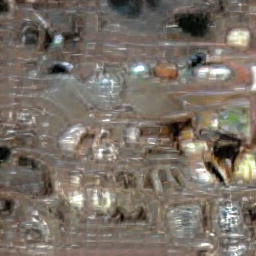

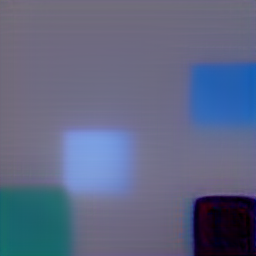

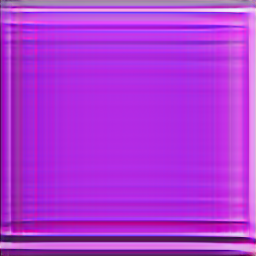

In [4]:
def show(image_seq, save=None):
    image = image_repr.tensor_to_image(image_repr.decode(image_seq)[0])
    display(image)
    if save:
        image.save(save)
    return image

corrupt_image_seq = image_repr.rand_image_seq(1, device='cuda')
show(corrupt_image_seq)

corrupt_image_seq = image_repr.rand_image_seq(1, device='cuda', patch_size=4)
show(corrupt_image_seq)

corrupt_image_seq = image_repr.zeros_image_seq(1, device='cuda')
show(corrupt_image_seq)

print('')

In [ ]:
top_k = 0
temperature = 1

indices = list(range(3))

for idx in indices:
    track = dataset.tracks[idx]
    print(f'{track["genre"]}: {track["title"]} ({track["id"]})')
    
    audio, ref_image_seq = dataset[idx]
    
    audio = audio[None, ...].to('cuda')
    ref_image_seq = ref_image_seq[None, ...].to('cuda')

    print('ref')
    show(ref_image_seq)
    
#     print('from_zeros')
#     image_seq = model.generate_image_seq(audio,
#                                          top_k=top_k,
#                                          temperature=temperature,
#                                          corrupt_image_seq=image_repr.zeros_image_seq(1, device='cuda'))
#    show(image_seq)
    
    for i in range(1):
        print('from_rand')
        image_seq = model.generate_image_seq(audio,
                                             top_k=top_k,
                                             temperature=temperature,
                                             corrupt_image_seq=image_repr.rand_image_seq(1, patch_size=4, device='cuda'))
        print((image_seq == ref_image_seq).sum())
        show(image_seq)
        
    print('from_corrupt')
    corrupt_image_seq = visualizer.corrupt_image_seq('uniform',
                                                     image_repr.vocab_size(),
                                                     <ref_image_seq[0].clone())[None, ...]
    image_seq = model.generate_image_seq(audio,
                                         top_k=top_k,
                                         temperature=temperature,
                                         corrupt_image_seq=corrupt_image_seq)
    print((corrupt_image_seq == ref_image_seq).sum())
    print((image_seq == ref_image_seq).sum())
    show(image_seq)
    
    print('corrupt')
    show(corrupt_image_seq)

In [6]:
from IPython.display import Audio

track_idx = 5
path = scdata.get_audio_path(os.path.join(DATA_DIR, 'audio'), dataset.tracks[track_idx]['id'])
print(path)
Audio(path)

/home/leo/src/scdata/audio/334/334975142.mp3


In [7]:
mel = torch.tensor(dataset.load_features(track_idx), dtype=torch.float)
mel = (mel - dataset.mfcc_mean) * dataset.mfcc_std_inv
print(mel.shape)
print(mel.shape[0] / 21)

torch.Size([1533, 20])
73.0


In [8]:
import msaf

boundaries, labels = msaf.process(path)

In [9]:
boundaries

array([ 0.        ,  3.80807256, 17.83292517, 31.90421769, 46.90430839,
       57.21396825, 71.23882086, 71.25002268])

In [10]:
labels

[0.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0]

In [11]:
dataset.tracks[4]

{'artwork_url': 'https://i1.sndcdn.com/artworks-000234789846-yxvpty-large.jpg',
 'caption': None,
 'commentable': True,
 'comment_count': 24,
 'created_at': '2017-07-23T10:59:52Z',
 'description': 'What is your driving force?\n\nPhoto by Nik MacMillan on Unsplash',
 'downloadable': True,
 'download_count': 35,
 'duration': 136240,
 'full_duration': 136240,
 'embeddable_by': 'all',
 'genre': 'Jazz & Blues',
 'has_downloads_left': True,
 'id': 334422210,
 'kind': 'track',
 'label_name': None,
 'last_modified': '2021-03-27T19:52:51Z',
 'license': 'cc-by',
 'likes_count': 67,
 'permalink': 'driving-force',
 'permalink_url': 'https://soundcloud.com/the-fisherman/driving-force',
 'playback_count': 1148,
 'public': True,
 'publisher_metadata': {'id': 334422210,
  'urn': 'soundcloud:tracks:334422210',
  'artist': 'The Fisherman',
  'contains_music': True,
  'isrc': 'USDY41856174',
  'explicit': False,
  'writer_composer': 'Antonios Panou'},
 'purchase_title': None,
 'purchase_url': None,
 'rel

In [ ]:
from IPython.display import clear_output

from scipy.ndimage import gaussian_filter1d

from librosa.onset import onset_strength
from librosa.beat import beat_track

from aural_travels import generate

frames_dir = os.path.join(MODEL_DIR, 'gen', 'frames') 
os.makedirs(frames_dir, exist_ok=True)

track_idx = 5
last_image_seq = image_repr.rand_image_seq(1, device='cuda', patch_size=2)

mel = torch.tensor(dataset.load_features(track_idx), dtype=torch.float)
mel = (mel - dataset.mfcc_mean) * dataset.mfcc_std_inv

path = scdata.get_audio_path(os.path.join(DATA_DIR, 'audio'), dataset.tracks[track_idx]['id'])
y, _ = librosa.load(path, sr=dataset.sample_rate, mono=True)
onset_env = onset_strength(y, sr=dataset.sample_rate)
onset_env_filtered3 = gaussian_filter1d(onset_env, 3)
onset_env_filtered2 = gaussian_filter1d(onset_env, 2)

bpm, beats = beat_track(y, sr=dataset.sample_rate, units='time')

def noise(time, next_time, image_seq):
    generate.onset_env_noise(image_repr=model.image_repr,
                             onset_env=onset_env,
                             time=time,
                             next_time=next_time,
                             image_seq=image_seq,
                             power=2,
                             scale=10)
#     generate.beat_cross_noise(image_repr=model.image_repr,
#                               beats=beats,
#                               time=time,
#                               next_time=next_time,
#                               image_seq=image_seq)
#     generate.segment_reset_noise(image_repr=model.image_repr,
#                                  boundaries=boundaries,
#                                  time=time,
#                                  next_time=next_time,
#                                  image_seq=image_seq)
    ...
    
def temperature(time, next_time):
    #return 1.1
    return generate.onset_env_temperature(onset_env_filtered2, time, next_time) ** 0.8

keyframes = generate.keyframes(model=model,
                               mel=mel,
                               last_image_seq=last_image_seq,
                               fps=10.0,
                               noise=noise,
                               temperature=temperature,
                               device='cuda')

frames = generate.interpolate(image_repr=image_repr,
                              keyframes=keyframes,
                              interframes=6)

for i, frame in enumerate(frames):
    image = image_repr.tensor_to_image(frame)
    if i % 100 == 0:
        clear_output(wait=True)
        display(image)
        ...
    image.save(os.path.join(frames_dir, f'{i}.png'))

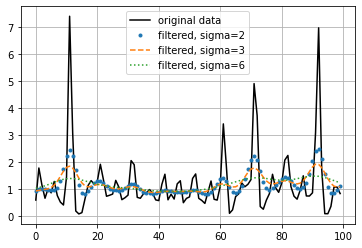

In [34]:
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

t1=1000
t2=1100
plt.plot(onset_env[t1:t2], 'k', label='original data')
plt.plot(gaussian_filter1d(onset_env, 2)[t1:t2], '.', label='filtered, sigma=2')
plt.plot(gaussian_filter1d(onset_env, 3)[t1:t2], '--', label='filtered, sigma=3')
plt.plot(gaussian_filter1d(onset_env, 6)[t1:t2], ':', label='filtered, sigma=6')
plt.legend()
plt.grid()
plt.show()

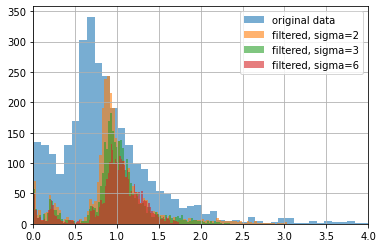

In [31]:
plt.hist(onset_env, bins=100, alpha=0.6, label='original data')
plt.hist(gaussian_filter1d(onset_env, 2), bins=100, alpha=0.6, label='filtered, sigma=2')
plt.hist(gaussian_filter1d(onset_env, 3), bins=100, alpha=0.6, label='filtered, sigma=3')
plt.hist(gaussian_filter1d(onset_env, 6), bins=100, alpha=0.6, label='filtered, sigma=6')
plt.xlim(0,4)
plt.legend()
plt.grid()
plt.show()

In [ ]:
def show_gif(fname):
    import base64
    from IPython import display
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

show_gif(os.path.join(frames_dir, 'out.gif'))

In [ ]:
from IPython.display import Video
Video(os.path.join(frames_dir, 'out.mp4'), embed=True)